# Autodiff Documentation
### Harvard Fall 2022
### Team 31: Cyrus Asgari, Caleb Saul, Sal Blanco, James Bardin

### Introduction

Automatic differentiation is a widely used tool for optimization, encompassing a set of efficient techniques used to computationally evaluate a function's derivative or gradient. At its core, automatic differentation exploits the idea that every function can be broken down into a sequence of elemenatry arithmetic operations and functions. Applying the chain rule to these operations in succession allows us to evaluate the derivatives we seek to high precision, without rampantly growing the number of arithmetic operations the computer needs to perform. As functions grow in size, complexity, and dimension, the need for an efficient algorithm to accurately derive the gradient becomes clear. The goal of our project is to develop a software library for automatic differentiation with both a forward mode and a reverse mode implementation to provide such efficient and accurate derivative calculations.

The applications of automatic differentiation are vast and ever-expanding. Ranging from finding the solution to ordinary differential equations (ODEs) and optimizing objective functions, to finding the solution of linear systems as an alternative to iterative methods, automatic differentiation is a highly useful technique. Many popular machine learning libraries such as PyTorch make use of such automatic differentiation. Prominent example applications span essentially any gradient-based optimization algorithm, including Newton’s method, training neural networks, sampling high-dimensional Bayesian model posteriors, and Hamiltonian Monte Carlo samplers $^{(1)}$. Speeding up computation and eliminating round-off error is crucial in applying modern gradient-based optimization algorithms across science and engineering. Automatic differentiation, as opposed to alternatives such as symbolic and numerical differentiation, holds many advantages in terms of both its efficiency and accuracy. As models – especially in neural network-based machine learning – become more complex and high-dimensional data becomes more readily available, the ability efficiently to compute derivatives is only becoming more important.

$^{(1)}$ *A Review of Automatic Differentiation and its Efficient Implementation* (Margossian)

------

### Background

#### Forward Mode
Automatic differentiation is a set of techniques to computationally determine a function's gradient, centered around an iterative evaluation of the chain rule.  This piecewise evaluation of the chain rule to find a derivative stems from the idea of breaking down complex functions into a sequence of elementary operations (addition, multiplication, etc.) and elementary functions (sin, exp, etc.), from the inside of the function outwards.  This sequence of elementary operations and functions that string together to create the function definition gives rise to the forward primal trace of the function.  Using our function inputs and evaluating through this sequence, we can see that at each stage in the sequence we will get an intermediate result $v_j$ that is dependent on our inputs.

The breakdown of a complex function into this sequence of elementary operations and functions (from the inside out) is most easily visualized in what we call the computational forward graph.  Our inputs $x_k$ to the original complex function represents nodes $v_{k-m}$ for $k$ = 1,2,...,m.  As we pass through the sequence, each intermediate results $v_j$ is alloted a node while the directed edges connecting nodes represent the elementary operation/function that leads to that intermediate result (a new node on the graph).

To compute the given derivative of the complex function we need to define a differential operator $D_p(.)$ representing the directional derivative in the direction of $p$ (note: $p$ is the seed vector that the user chooses if they desire a certain derivative of interest). Then, when we evaluate the forward primal trace of the function (finding all the intermediate values $v_j$), we also simultaneously evaluate (and carry forward) $D_p v_j$, the derivative of $v_j$ in direction of $p$.  Thus, for each step in the sequence we get both an intermediate value $v_j$ based on previous $v_j$'s  from the forward primal trace but also a value $D_p v_j$ based on the previous $D_p v_j$'s.  The sequence of formulas that define $D_p v_j$ at every step for a given value of p is called the forward tangent trace. Every time we wish to compute the derivative in a new direction we must perform a new pass through the forward tangent trace, plugging in a different $p$ direction vector to our $D_p v_j$'s at each step to find their values.

An important aside in the calculation of our gradients is the application of the chain rule touched on above. The chain rule allows the representation of a functions derivative in terms of the composition of multiple differentiable functions. Beginning with a simple example, we can consider a function in the form $f(g(t))$.  As a result of the chain rule we write its derviative as $\frac{df}{dt} = \frac{df}{dg} \cdot \frac{dg}{dt}$. We can expand this concept to higher dimensions to further generalize our chain rule. With a multivariate function, it is important to consider the gradient, which represents the summation of the partial derivatives of f to its inputs. We can thus write our generalized chain rule as follows: $\nabla_x f = \sum_{i=1}^n \frac{\partial f}{\partial y_i} \nabla y_i (x)$.

One structure that is critical in the implementation of forward mode AD is dual numbers.  A dual number $z$ takes the form $z = a + b\epsilon$ where $a$ is the real part, $b$ is the dual part, and $\epsilon$ is a nilpotent number such that $\epsilon^2 = 0$ (note: $\epsilon$ does not equal 0). They have three very useful properties:
1. Adding dual numbers together resembles the linearity of addition and results in adding the functions in the real part and adding the derivatives in the dual part
2. Multiplication results in multiplication of the functions in the real part and the product rule for the derivatives in the dual part
3. Chain rule still holds for dual numbers

Because of these properties, dual numbers can be used to efficiently encode the primal and tangent trace of intermediate results $v_i$ and $v_j$ as we pass forward through the sequence (computational graph).  Letting $z_j = v_j + D_p v_j \epsilon$ for intermediate results, we are able to conveniently store the primal trace and the tangent trace in the real and dual part (respectively) of a dual number ($z_j$) allowing us to carry them forward through the sequence as a pair.

-----

### How to Use Autodiff

#### Autodiff Installation

Our package is available for installation via TestPyPI. We decided to use TestPyPI as our project is still in experimentation stages and felt this would be the better suited option. Below are the detailed steps for creating a virtual environment in which to install and use our package effectively.

1. Navigate to desired directory and create virtual environment
```python
python -m venv test_env
```
2. Activate the environment 
```python
source test_env/bin/activate
```
3. Navigate inside test_env and install dependencies
```python
cd test_env
python -m pip install numpy
```
4. Install our package
```python
python -m pip install -i https://test.pypi.org/simple/ autodiff-team31==0.0.1
```
5. Write your code and import our package!

```python
import autodiff as ad
ad.sin(1)
0.8414709848078965
# More examples below
```
6. Deactivate the environment 
```python
deactivate
``` 


#### Autodiff in Practice

The core of our autodiff library is the Func class. Through its use, users can use forward mode AD to find the jacobian of a function at a given point or to evaluate both the function value and the derivative in a given direction at a given point.  Steps for this, with example code, are outline below:

1. Import autodiff along with its Func module
```python
>>> import autodiff as ad
>>> from autodiff.func import Func
```
2. Define the function they wish to differentiate using traditional Python function defintions or lambda functions. Note: if the function definition involves sines, cosines, exponents, etc., users should use the autodiff functions (ad.sin, ad.cos, ad.exp, etc.) in their function defintion.
```python
>>> def g(x, y):
        return y + x**2, x - 3*y
```
3. Instantiate a Func object.  Note: Func takes 3 parameters:
    * function : function object
        * The user-defined mathematical function that users wish to differentiate.
    * num_inputs : int
        * The number of inputs to the function users wish to differentiate.
    * num_outputs : int
        * The number of outputs to the function users wish to differentiate.
```python
>>> gofx = Func(g,2,2)
```
4. 
    * To find the jacobian users can call the 'jacobian' method of their Func instance.  Note: jacobian takes 1 parameter:
        * point : int, float, list, np.ndarray
            * The input point at wish users wish to evaluate the function's jacobian. Can be int/float if & only if input dimension = 1.
    * This method returns the jacobian of the function at the inputted point. When the jacobian is a scalar, it returns a float.  Otherwise, it returns a num_outputs by num_inputs numpy array. <br><br>   
    * To evaluate the function value and the derivative value users can call the 'eval' method of their Func instance. Note: eval takes 2 parameters:
        * point : int, float, list, np.ndarray
            * The input point at wish users wish to evaluate the function and the function's derivative. Can be int/float if & only if input dimension = 1.
        * seed_vector : list, np.ndarray
            * The direction in wish users wish to evaluate the function's derivative
    * This method returns a tuple.  The first element is an np.ndarray with num_outputs' length representing the function evaluated at the given point.  The second element is an np.ndarray with num_outputs' length representing the value of the derivative at the given point in the given direction.           
```python
>>> gofx.jacobian([4,2])
array([[ 8.,  1.],
       [ 1., -3.]])
>>> gofx.eval([4,2], [1,0])
(array([18., -2.]), array([8., 1.]))
```            

See details demos of how to use every feature in autodiff below:

-------

### Forward Mode AD Demos

#### Evaluating the function value at a point

In [30]:
#importing the library
import autodiff as ad
from autodiff.func import Func


#defining a function
def fofx(x,y,z):    
    return ad.sin(2*x) - y/z, 3**ad.sqrt(y) * ad.log(2.5*z*y*x)


#creating a func object
f = Func(fofx, num_inputs = 3, num_outputs = 2)

#evaluatig the function at the point
point = [np.pi, 4, 3.2]
f_val = f(point)

print(f'function val:\n {f_val}')

function val:
 [-1.25      41.4941921]


#### Evaluating the jacobian at a point using forward mode

In [29]:
f_jacobian = f.jacobian(point)
#to be explicit one could also call f.jacobian(point, feval = False, reverse = False)

print(f'function jacobian:\n {f_jacobian}')

function jacobian:
 [[ 2.         -0.3125      0.390625  ]
 [ 2.86478898 13.64650734  2.8125    ]]


Users also have the option to return the function value calculated at the point and the jacobian by setting feval = True:

In [27]:
f_val, f_jacobian = f.jacobian(point, feval = True)

print(f'function val:\n {f_val} \n\nfunction jacobian:\n {f_jacobian}')

function val:
 [-1.25      41.4941921] 

function jacobian:
 [[ 2.         -0.3125      0.390625  ]
 [ 2.86478898 13.64650734  2.8125    ]]


#### Evaluating the function value and directional derivative at a point

In [32]:
direction = [3, 1, 2.5]

f_val, f_dd = f.trace(point, direction)

print(f'function val:\n {f_val} \n\ndirectional deriative in direction {direction}:\n {f_dd}')

function val:
 [-1.25      41.4941921] 

directional deriative in direction [3, 1, 2.5]:
 [ 6.6640625  29.27212426]


### Reverse Mode AD and Computational Graph Demos

#### Evaluating the jacobian at a point using reverse mode

In [60]:
#defining a function
def fofx(u, v, w, x, y, z):    
    return u*v*w/(x**2) - 10 + y*z*x**3, 8*w**z - 4*w + ad.exp(4*y+4)**ad.exp(y-z + w) - u/v 


#creating a func object
f = Func(fofx, num_inputs = 6, num_outputs = 2)
point = [5, 4, 3.2, np.exp(1), np.pi/3, 4]

f_jacobian = f.jacobian(point, reverse = True)

print(f'function jacobian:\n {f_jacobian}')


function jacobian:
 [[ 1.73229163e+00  2.16536453e+00  2.70670566e+00  8.64808727e+01
   8.03421477e+01  2.10335251e+01]
 [-2.50000000e-01  3.12500000e-01  3.76221525e+05  0.00000000e+00
   5.58440625e+05 -3.74201228e+05]]


#### Displaying the computational graph for an $\mathbb{R}^n \rightarrow \mathbb{R}$ function

First for a simple function:

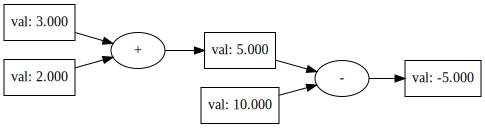

In [64]:
def simple_fofx(x,y,z):
    return x + y - z

simple_f = Func(simple_fofx, num_inputs = 3, num_outputs = 1)
simple_point = [3,2,10]

simple_f.graph(simple_point)

For a more complicated function:

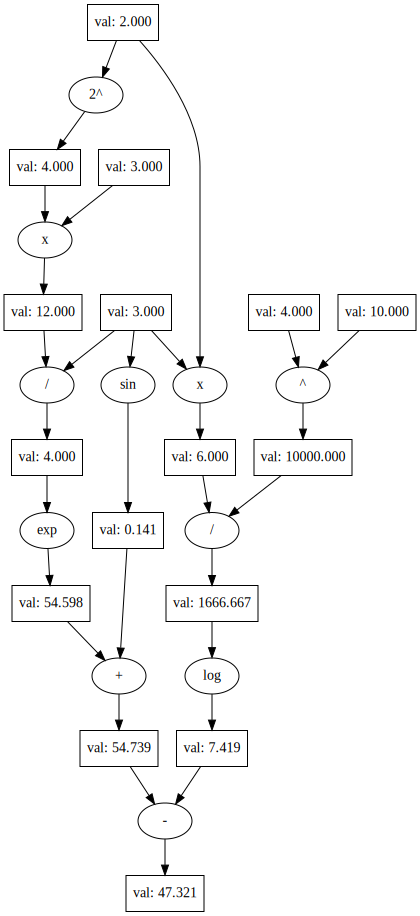

In [68]:
def fofx(x,y,z):
    return ad.sin(x) + ad.exp(2**y *  3/x) - ad.log(z**4/(x*y))

f = Func(fofx, num_inputs = 3, num_outputs = 1)
point = [3,2,10]

#with the graph direction option we specify if we want the graph orientation
#'LR'(default), left-to-right, or 'TB', top-to-bottom
f.graph(point, graph_direction= 'TB')

-----

### Software Organization

This section provides a high-level overview of how our software is organized.  
  
Our directory structure is as follows – autodiff is the name of our package:
```
team31 
├── LICENSE    
├── pyproject.toml      
├── README.md
├── setup.cfg
├── docs
│    ├── milestone1.ipynb
│    ├── milestone2.ipynb
│    ├── milestone2_progress.md
│    └── documentation.ipynb
├── src
│    └── autodiff
│            ├── __init__.py 
│            ├── dualnumber.py 
│            ├── func.py
│            ├── operators.py
│            └── rNode.py
└── test
     ├── run_tests.sh
     ├── check_coverage.sh
     ├── test_dualnumber.py
     ├── test_rNode.py
     ├── test_func.py 
     ├── test_operators.py 
     ├── parser.py
     └── coverage.xml

```

Our AD library is built on 4 central modules:

- DualNumber
    - Within the dualnumber module we define the DualNumber class which, although never accessed directly by the user, forms the foundation of our forward mode implementation. We specify in the class constructor the attributes that uniquely identify dual numbers, the real (self.real) and dual (self.dual) parts.  Then we overload all the operators for basic arithmetic (+, -, \*, /, etc.) and their reverse options to ensure that DualNumber instances can be used in user defined functions.  Throughout the class we provide checks for the type of inputted or interacting objects as we intend to support int, float, and DualNumber operations with DualNumbers but raise errors otherwise.  Specific implementation details are further described below.
- rNode
    - Within the rNode module we define the rNode class, which, like the DualNumber class, is never directly accssed by users, but forms the foundation for the reverse mode and computational graph capabilities of our library.  In the class constructor we specify the attributes which will uniquely define a specific node – it's value, the value of the adjoint at this node in the function, the node's parents, the operator used to create this node, the node's unique name, and the backwards function "backward_func" reflecting how to accumulate the gradient for this node's parents in the reverse pass.  Much like the DualNumber class, we then overload all the operators for basic arithmetic (+, -, \*, /, \*\*, etc.) along with their respecive reverse operators to ensure that the rNode class won't raise errors if used with acceptable input types in the user defined functions. In each of these operator overloads we ensure that we are returning a new rNode type with the correct value, parents, backward_func, and operation given. Throughout the class we provide checks for the type of object that is interacting with rNode as we intend to support int, float, and rNode operations with rNode but raise errors otherwise.  We also define a method to topologically sort the nodes based on their parents and how they were created in the function.  This mehtod gets called by another method we define called backward, which is called to calculate the gradient of a user defined function with respect to the given node it is called on by traversing backwards and accumulating the gradient.  We also implement a graph_object method which traverses back through a nodes parents recursively and returns the nodes and edges objects needed to use Digraph to create a graph visualizations.  Although all these methods are implemented, they will never be called by users directly and instead will be used under the hood in the Func class.  Specific implementation details are further described below.
- Func
    - Within the func module we define the Func class, the heart of our AD implementation and that with which users will interact the most. Func class objects take as input, and store as attributes, the function a user wishes to differentiate, the number of inputs, and the number of outputs.  Func objects have three key methods: jacobian() and trace().  The jacobian method is used to find the jacobian of the function at an inputted point.  It has an option to calculate this jacobian with forward mode or with reverse mode AD, and also has an option for if users would like to return the function value at that point in addition to the jacobian. Lastly, calling trace() with a point and seed vector as inputs  returns a tuple where the first element is an array representing the function's value at the inputted point and the second element is an array representing the value of the derivative at the inputted point in the direction of the inputted seed_vector.  This allows users to get directional derivative of their function rather than just the jacobian. Throughout the class we implement checks to raise errors if we encounter dimensions mismatches or invalid inputs. Specific implementation details are further described below.
    
- Operators
    - Within the operators module we define several functions (sin, exp, log, etc.) to specify how basic unary operations should be carried out during function evaluation in AD.  Notably, we designate how these operators should act on DualNumber instances, on scalars (ints/floats), between DualNumber instances and scalars (ints/floats), on rNode instances, and between rNode instances and scalars.  These defined operators allow users to define the functions they wish to differentiate with ant operator compatible with our AD library in an intuitive way.  There are also checks within this class to determine the type of input such that each function returns the desired result or, in the case of an invalid input, an error. Specific implementation details are further described below.


Test Suite:

Our tests reside in a separate test directory that reflects our src directory. We have created a script, run_tests.sh, to run all tests within our directory with pytest. We have extensive unit tests implemented for the DualNumber class, operators, rNode, and the Func class. We also have developed integration tests that use our func module to ensure that it can correctly derive the jacobian with forward and reverse mode for complex functions. Additionally, we have created a coverage check, runnable via the script check_coverage.sh, that will generate a coverage report that is passed into a coverage.xml file. From here, we have also created a parser python file that extracts the coverage percentage from this coverage.xml file and determines whether it meets our threshold of 90%. This is run by our coverage workflow, which calls the check_coverage.sh script followed by parser.py to determine if we have met our coverage criteria. Currently we have achieved a coverage well over 90%. Similarly we have a workflow that ensures all tests passed by running the run_tests.sh script.


Package Installation:

Our package is available for installation via TestPyPI with PEP517/518. As such, we have included the required pyproject.toml file with our package metadata, as well as a setup.cfg file as we use setuptools for our backend. This enables easy building and distribution of our package.  Please refer to the **How to Use Autodiff - Autodiff Installation** section for a step by step guide, with example code, of how to install autodiff on your machine.


-----

### Implementation

The implementation of our AD library relies on the integration and interaction between our 4 core modules: dualnumber, rNode, func, and operators.  Broadly, dualnumber provides the DualNumber class, rNode provides the reverse node class, func defines the Func class, and operators handles all the elementary function defintions.  Here we will discuss dualnumber, the forward mode elements of Func, and operators.  Discussion of the rNode and the reverse mode capabilites of Func will be described in extension.

- Core classes and Important Attributes Forward Mode AD
<br><br>
    - The current core classes in the forward mode autodiff implementation are the DualNumber class and the Func class, defined in their namesake modules.  The attributes and methods of these classes allows them to work together in performing forward mode AD.  While not a class, the operators module defines several functions key to the user experience working with our library.<br>

   **DualNumber()**
<br><br>
        - The main purpose behind DualNumber is to create a class of objects to encode the current state of a dual number (a+b$\epsilon$, where $\epsilon^2$ == 0)  such that it can be used in function operations, as is needed in automatic differentiation.  The class constructor takes two arguments – real and dual – representing the real and dual parts of the specified dual number.  These values are stored as attributes of the instance, self.real and self.dual, such that they can be accessed later by class methods ore be updated or used in the instantiation of a new DualNumber object.  Within DualNumber, we implement a series of dunder methods to overload basic operators, comparative operators, and functions  (+, -, \*, /, pow, etc.), along with their reverse options, to accurately reflect how arithmetic between dual numbers themselves and between dual numbers and scalars (ints/floats) is performed.  When carrying out operations between two DualNumbers, the result's real part is created by performing the specified operation between both of the original's real parts. The dual part, however, is created by performing the first order differentation of said specified operation.  Because this is not how Python naturally implements these basic operators, it was essential for us to overload in order to ensure compatibility with dual number arithmetic.  Throughout the class there are a series of checks to ensure that any inputs to the methods are of valid type (ints, floats, or dual numbers).<br><br>
        
   **Func()**
   <br><br>
        - Func class instances serve as the clients main point of interaction with our AD library.  The class constructor takes 3 inputs: function, num_inputs, and num_outputs. Function is the defined function the users wishes to differentiate and will be stored as an attribute in self.func (since functions are first class objects in Python). Num_inputs and Num_outputs represent the respective input and output dimension of inputted function and will be stored in the attriutes self.num_inputs and self.num_outputs.  These attributes allow Func to internally initialize NumPy arrays of the correct size for storing jacobian or derivative evaluations and make it possible to refer back to the user defined function when calculating values and derivatives.  Within the function class we also define 7 methods:
       <br> <br>
       We define the \_\_call\_\_() mehtod in the Func class such that when an instance of Func is called with a point as the argument, it will return the function evaluation at that point.  This is very intutive and reflective of the usage of native Python functions.  Within the method we carry out several checks to ensure the dimensionality of the inputted point and the output matches the sepcified number of inputs and outputs of the user defined function before returning, self.func(point), the function evaluated at the given point.
       <br> <br>
       \_forward(), a method the user will not interact with but is called internally by Jacobian(), is used to return the value of the function at an inputted point and the jacobian matrix (or scalar in the case of scalars) of the function at at an inputted point using forward mode AD. Internally it creates an identity matrix of dimension num_inputs by num_inputs where each column represents a seed vector.  At the same time it initializes a num_outputs by num_inputs matrix of zeros which will store the jacobian values. A for loop then iterates through the columns of the identity matrix, setting that iteration's column to be the seed_vector of choice. In each loop, jacobian() initializes num_inputs dual numbers from the DualNumber class where dual number i is: $z_i$ = DualNumber(p[i],seed_vector[i]). It then calls self.func($z_1$...$z_{num\_inputs}$) which returns a dual number (or sequence of dual numbers for multiple output functions), where the real part of the dual number(s) is the value of the function at the input point p and its dual part is the derivative of the function at point p in direction seed_vector. We will then store this derivative value (or vector if there are multiple outputs) in the corresponding column of our previously initialized jacobian matrix. Once we have looped through all the seed_vectors (and thus all the inputs), we will have found the values of the derivative of each output of the function with respect to each input of the function at the point p and stored them in the jacobian matrix.  During this loop we also store the real part of the dual numbers, representing the value of the function at the inputted point, in a previously initalized val array.  Thus, in the end we both have the value of the function as well as the jacobian matrix stored and we can return them.
       <br> <br>
        Jacobian() takes a point p, the point at which users want to evaluate the jacobian of the function as an input (p has dimension num_inputs). It also takes a boolean value for feval and reverse – defaults for both are false.  When reverse = False, jacobian internally calls the \_forward method on the inputted point and gets the value of the function at the derivative and the jacobian matrix.  If feval = True then the function value and the derivative are returned in a tuple while if false just the jacobian matrix is returned. We also check if the jacobian is a scalar (a 1x1 matrix) in which case we return just the scalar value. Otherwise, the num_outputs by num_inputs jacobian matrix is returned.  Before any of the process starts we also check that point is of acceptable type and dimension and reverse is of acceptable type.
        <br> <br>
       Trace() takes two inputs, a point p (the point where users want to evaluate the function and derivative) and a direction (seed_vector), the direction in which users want to evaluate the directional derivative (eg. seed_vector = [1,0,0,0]).  Like the jacobian() method, internally the trace() method will also define num_inputs dual numbers $z_i$, where $z_i$ = DualNumber(p[i],seed_vector[i]).  Trace() then calls self.func($z_1$...$z_{num\_inputs}$) to generate a dual number (or sequence of dual numbers for multiple output functions), where the real part of the dual number(s) is the value of the function at the input point p and its dual part is the derivative of the function at point p in direction seed_vector. The real part(s) of the(se) dual number(s) is stored in an array called val and the dual part is stored in an array called deriv.  Finally, the method returns the val array and deriv array in a tuple where the first element (val) represents the function's value evaluated at the inputted point and the second element (deriv) represents the value of the derivative at the inputted point in the inputted direction.  Throughout the entire class we implement checks to raise errors if we encounter dimensions mismatches or invalid inputs (eg. inputted points must be int, float, list, or NumPy Arrays; strings will raise an error). 
<br><br>

    __Operators__ (elementary functions)
 <br><br>
        - While our operators module is not a class, it is an important aspect of our implementation as we define functions such as sin, cos, tan, log, log_base, exp, arcsin, arccos, arctan, sinh, cosh, tanh, logitsic (sigmoid), sqrt. Here, we make use our numpy dependency and define these elementary functions for ints, floats, dual numbers, and rNodes (see extension for explanation). For the dual number implementation, we utilize the chain rule to properly evaluate the dual component and return a new dual number object.  For reverse mode, we differentiate the function to find what the adjoint should be for the nodes involved in the function and define a backward_func to assign to the returned node such that it parent's deriavtives will be updated accurately during the backwards pass (see extension for reverse mode details).  As a result of our implementation of these operators, we allow users to make functions using syntax such as ad.sin(x), which is much more intuitive and reflective of a numpy implementation. Additionally, we include checks to ensure the input is of the proper type.
    
    <br><br>
- Core data structures
    - Lists, Arrays, & Tuples: The key data structures used in autodiff are lists, NumPy arrays, and tuples.  Most notably, for functions with multiple inputs and outputs, the parameters to the methods in our Func class will have to be lists or np.ndarrays.  For higher dimensional functions, our Func methods also return the elements of the output – a jacobian matrix for the jacobian() method and the function value and directional derivative for the trace() method – as np.ndarrays.  This is because many functions in the NumPy library are already highly optimized for np.ndarray objects.  If users wanted to transform the output of their AD call (such as find the inverse of the jacobian), they could easily use NumPy functions on the returned objects without worries of suboptimal performance.  Internally, a list is used to store the DualNumber object inputs that are generated from the user inputted point and seed_vector (see Func implementation for details); the same is true when we do reverse mode with rNode.  This is convenient as when we call self.func() on the list of DualNumbers or rNode objects, we can simply use the * to unpack the list items to serve as inputs to the function.  Tuples are used when we return from the trace() method of func or the jacobian method with feval = True. We use tuples as a convenient way to output two different objects such that they can be indexed later or assigned automatically.  Tuples are also fed to our graphing methods in func (see more later), because we use tuples of nodes to indicate which nodes on the graph should have an edge between them.<br><br>
    - Directed Acyclic Graph: For the implementation of reverse mode automatic differentiation and the construction of our computational graph for visualization, we made use of a directed acyclic graph data structure (DAG). This is a specific type of graph with directed edges such that no cycles are present. We note that this is similar to a binary tree with the exception of having multiple possible roots. Each node in our graph data structure is of type rNode. The nodes have a value parameter, in addition to a derivative parameter. Further, the nodes contain reference to their parents, and have degree of 0, 1, or 2, given how we parse a function. By maintaining a reference of a node's parents, we are able to traverse across our graph in the reverse pass of reverse mode. Additionally, we are able to use this graph data structure to create a Digraph for visualization using the graphviz package.
    
<br><br>
- External dependencies
<br><br>
    - For our AD library, we will rely on both the NumPy package and graphviz package. as our sole external dependency. NumPy is a package which is extremely resourceful for supporting arrays, matrices, and other mathematical operators which are omitted from the native pythonic library. It was necessary for importing sin, cosine, and tangent functions which are used in writing the DualNumber operators in our operator.py file. Additionally, we introduce the numpy natural log function which is essential for overloading our "pow" and "rpow" methods in the DualNumber class.  They are used similarly through the rNode class (see extension). It is also used to support virtually all the functions defined in our module operators.py. Lastly, as stated before, numpy provides us with the nd.array type which can be used to create matrices of any shape. We use the np.zeros and np.identity methods for implementing our Jacobian and derivative evaluation functions and storing the results in func.py. It is also important to highlight that our functions support numpy arrays as input values given our dependency on the module. We decided to use numpy over the pythononic math module since numpy allows for the handling of array inputs; the math function methods only support scalar inputs, which would make the scope of our package much more narrow.<br><br>
    - We use the graphviz package, and specifically a function called Digraph, to build our computational graph in the graph() method of the Func class.  The graphviz package is meant to ease the creation and viewing of graph in terms of DOT language of the Graphviz graph drawing software (an upstream repository) from Python.  It allows users to create a graph object and assemble it by adding nodes and edges, as we do in our graph() method of func using rNodes as nodes and creating edges to represent function operations between two rNodes.  These graph objects are easily displayed in Jupyter notebooks, very common in data science applicatins, which lends itself nicely to our project.
<br><br>  
  
   


-----

### Extension

### Reverse Mode

#### Reverse Mode Background
While the forward mode implementation described in the background section holds many advantages for the evaluation of a function and its gradient, it has shortcomings when dealing with functions of high dimensions. In particular, for functions $f: \mathbb{R}^m:\mathbb{R}$ for large $m$, forward mode requires $m$ passes to determine the gradient of $f$. This is a common scenario for neural networks, and is where the alternative technique of reverse mode excels.

Reverse mode, as opposed to forward mode, requires only two passes to determine the gradient of a function. The first pass, named the forward pass, computes the primal trace $(v_j)$ as well as the partial derivatives with respect to the parent nodes. However, unlike in forward mode, the chain rule must not be explicitly applied. Instead, we then perform the reverse pass, where the chain rule will be reconstructed by accumulating values as we traverse backwards across our computational graph. The result is a calculation of the gradient, with a computational cost not dependent on $m$ as forward mode is. However, reverse mode does have limitations in the sense that we must store the computational graph of our function which may be memory intensive. For a forward mode implementation, we iterate over the graph sequentially and do not need to return to prior nodes, whereas for the reverse pass in our reverse mode implementation these previous nodes must be stored as they are later revisited. Hence, reverse mode requires more memory allocation in terms of storing the computational graph of our function, but offers a substantial advantage in terms of its computational cost for functions where high dimension inputs. We will provide reverse mode as an extension of our automatic differentiation library.

#### rNode
The rNode class is the fundamental component of our reverse mode automatic differentiation. This node has the following attributes:
```python
self.val
self.der
self.backward_func
self.oper
self.parents
self.name
```
This allows us to maintain the function evaluation, recorded intermediately in the val attribute, as well the derivative, recorded in the der attribute. Additionally, we maintain reference of a node's parents, which creates a graph data structure that we utilize in our reverse pass. The backward_func is the function that is evaluated for a given node in the reverse pass to accumulate the derivative. Moreover, we maintain a name and operator parameter in the form of strings that are used when visualizing our computational graph, another component of our extension.

Within the rNode class, we also override the dunder methods for basic arithmetic as well as unary operators. This includes the same dunder methods overriden within the DualNumber class. However, in defining these arithmetic operators, we define an inner _backward_fn() method that is utilized for the reverse pass accumulation of the derivative. These methods each return a new rNode object, with the updated value and references to its parent. Within the rNode class, we also employ our topological sorting which is discussed in more detail below, and is used when graphing our function.


#### Operators
Similar to how the dunder methods within the rNode class were overloaded, we added operators external to the rNode class such that users could still use elementary functions including trignometric, exponential, and various others. We incorporated the elementary functions for reverse mode into the existing operators used for forward mode. This prevents users from having to use separately defined operators, and thus is a large improvement over other naive implementations. This was accomplished by checking the instance of an input into these elementary functions. If the input was a scalar or DualNumber, it would be processed as previously, but if the input was of type rNode, we would perform our reverse mode operations. This entailed the evaluation of the node's value and derivative. The operators for rNode all include an inner _backward_fn() method, that is used in the reverse pass of reverse mode. This allows us to maintain the function evaluation and partial derivatives through the forward pass, and then accumulate via chain rule and passing by node parents to determine the full Jacobian in the reverse pass.



#### Integration with Func Module
We wanted users to be able to interact with our reverse mode implementation very easily. Rather than having users separately define functions for reverse mode, we allowed them to reuse a given function object for both forward and reverse mode automatic differentiation. Thus, ease of use was a high priority in our implementation. We accomplished this by including an optional parameter in our jacobian method, a boolean reverse, which was defaulted to False. This means that users can still evaluate the jacobian of a function with forward mode, but they may also utilize reverse mode by simply specifying reverse=True. This function then delegates its computation to private function _forward and _reverse depending whether forward or reverse mode is selected respectively. Within _reverse, we compute the jacobian of the function by performing a forward and reverse pass utilizing our rNode structure.


### Graph Visualization
We allow users to visualize their computational graphs for any functions $\mathbb{R}^m\to\mathbb{R}$. This is a very useful tool for users to better understand how a given function is parsed into nodes with individual evaluation steps. We are able to make use of our rNode class in forming this graph data structure, as we establish a directed graph that is passed to our topological sorter (described below). With our sorted sequence of nodes, we make use of our dependency to graphviz, and specifically the Digraph module to visualize our computational graph.

Furthermore, we offer users the option of visualizing their graph in a horizontal represention, denoted by graph_direction = 'LR', which is the default, or in a vertical representation, denoted by graph_direction = 'TD'. This is a useful convenience, particularly when dealing with larger, complex functions that may not be representable on a single screen.

Note: this visualization is currently only supported for functions with scalar output (but multidimensional input is acceptable).


### Topological Sorting
We also decided to implement a topological sorting algorithm to improve the efficiency of traversing our graph data structure. Since we have a directed acyclic graph formed when evaluating reverse mode, we are able to make use of a topological sort to determine the optimal order in which to evaluate the reverse pass of the nodes. This also ensures that we do not evaluate a node's derivative prior to any dependencies in the form of its parents due to our representation of edges from a node child to its parent.


### Sphinx
Finally, to reinforce our documentation and make our package easy to use, we also incorporating Sphinx. This allowed us to publish our documentation to a github pages website. Here, all of the classes and methods of our package are defined along with examples, so users can get a better grasp as to how to use autodiff. 

-----

### Broader Impact and Inclusivity Statement 

Our package was created to provide people with a user-friendly and readable introduction to automatic differentiation and its applications. We aimed to allow users to use our functions freely, handling input types and other specifications on the backend while maintaining functionality on the frontend. People will be able to efficiently perform forward and reverse mode automatic differentiation; additionally, this package supports function evaluations with specified parameters such as point and direction. We are certain that this software will provide consumers with unprecedented degrees of freedom given the input/output type support embedded within our functions; the computational possibilities are endless, ranging from basic elementary functions to the production of Jacobian matrices. This described versatility is deliberate, as we aimed to provide a multitude of services.

In an ideal world, the broader impact of our package ends there; however, it is essential to note the potential drawbacks of misuse and how that could impact our community. Forward and reverse mode automatic differentiation are a cornerstone of modern machine learning, specifically when training neural networks. These processes are used to fine tune input parameters (weights, biases, etc.) in hopes of producing a more accurate prediction. Today, there have been various cases of machine learning models propagating racism, sexism, and other forms of bigotry which are unacceptable to say the least. For example, in their 2018 research paper Gender Shades, Joy Buolamwini and Timnit Gebru touch upon a facial recognition model which performed better for lighter skinned individuals and worse for darker skinned individuals. A similar example comes from Nature Magazine, where researchers found that skin cancer classification models performed severely worse on darker skinned individuals; these models even optimized for lighter individuals as an attempt to maximize overall accuray. While these cases are not the norm in the field, they still require significant attention. It is our mission to provide our users with an unbiased, transparent tool, and we rebuke any implications that do not aim to do the same.

While we hope to make our package as inclusive as possible, there are evidently some "barriers to entry." Since most of our functionality is rooted in advanced mathematical topics, there are definitely features which some users will use ineffectively. We hoped to bridge that gap in the use of our comments and documentation, delineating inputs, outputs, and what our functions are performing; this use of text ensures that our consumers have a complete understanding of the intended and expected use. Additionally, each of our members comes from a different cultural, ethnic, and socioeconomic background. We aimed to make this product accessible and representative of all of our intended users. While we may lack gender diversity, our group deliberately made this product as gender-neutral as possible, emphasizing the validity and functionality of our solutions. Each addition to this project was carefully reviewed before finalizing its implementation. We ensured this by requiring that no one merge their own pull request so that the full team could provide extensive input before publishing it.

With all these thoughts in mind, we hope that you, our user, uses this package for its intended use. We anticipate our candidness sets an example for what we hope its impact to be.

-----

### Future Work

#### Graph Visualization for Vector Output
Our current implementation of graph visualization works for functions of $\mathbb{R^m}\to \mathbb{R}$ or similarly $\mathbb{R} \to \mathbb{R}$. Thus, it serves great functionality examining backpropagation or simply scalar output functions. However, we would like to expand this feature to be usable for functions of vector output. This would allow users to visualize more complex functions and better understand the computational graph.

#### Higher Order Derivatives
We seek to support the evaluation of higher order derivatives in conjunction with our current implementation of the jacobian. In particular, we would like to evaluate the Hessian of a function. Evaluating the Hessian is valuable in a number of different applications and algorithms. The Hessian can be utilized to determine the convexity of a function, and therefore is extremely valuable in optimization. The Hessian can be utilized for the evaluation of higher order Newton’s method for example. Users would be able to easily obtain the Hessian at a point using the Func class as follows:
```python
f.hessian(point)
```


#### Optimizers
One of the next major steps we would like to take is the implementation of optimizers. This feature is something we contemplated incorporating into our project but were limited in terms of time given our other extensions. We would like to implement optimizers such as stochastic gradient descent (SGD), adams, and adagrad. These are popular optimization algorithms that are available in other software such as Pytorch. The application of such optimizers are broad, as they serve a pivotal role in optimizing loss functions for the training of various machine learning algorithms. For instance, the formation of a neural network often involves the use of an optimizer such as adams, and thus we hope to be able to implement such a feature to give users more direct ability to apply our package for machine learning. This relates to our next feature as well, being backpropagation for neural networks, and it stems from a desire to have our package designed for use in machine learning. Since the applications of machine learning are incredibly broad, ranging from biology to statistics and many more subjects, we feel that gearing our package towards such functionality would be most useful. Below is our idea of how we intended on implementing these optimizers:

We would create an abstract optimizer class, and then implement various optimizers extending this class. We base our approach off of the usability of PyTorch.
```python
class Optimizer:
	def __init__(self, parameters):

	def step(self):
        pass

class SGD(Optimizer):
    def __init__(self, parameters):

	def step(self, lr, momentum):
        # TODO

class Adam(Optimizer):
    def __init__(self, parameters):

	def step(self, lr, decay):
        # TODO

```
#### Backpropagation for Neural Networks
Given that we have already implemented reverse mode automatic differentiation which works with vectorized inputs, a logical next step is to provide a more direct usability of our package for backpropagation. As mentioned above, we are eager to have our package utilized for machine learning applications, and given the versatility of neural networks, we desire to have easy integration of backpropagation. We already have activation functions implemented such as the logistic (sigmoid), and tanh, but we would also like to implement additional activiation functions such as ReLU, which can easily be incorporated into our operators module.
